In [32]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import numpy
import pickle
import os, sys
import scipy
import h5py
from scipy.signal import periodogram,get_window,coherence
from scipy.interpolate import interp1d
#from scdmsPyTools.Cuts.General import removeOutliers
#from scdmsPyTools.Traces.Stats import slope
#from scdmsPyTools.General.Complex import stdComplex
#from scdmsPyTools.Traces.Filtering import *
from scipy.stats import skew


#datapath = '/gpfs/slac/staas/fs1/g/supercdms/tf/northwestern/AnimalData/AR68dm/*/'
#pulsefiles=glob(datapath + series + '/*' + series + '*.hdf5')
sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

In [33]:
%matplotlib notebook

In [34]:
series    = '20220720_150715'
data_path = os.path.join('/data/USRP_Noise_Scans',series.split('_')[0],series)

In [35]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
# metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)

Line Delay file:  /data/USRP_Noise_Scans/20220720/20220720_150715/USRP_Delay_20220720_150715.h5
VNA scan file:    /data/USRP_Noise_Scans/20220720/20220720_150715/USRP_VNA_20220720_150715.h5
Timestream files: ['/data/USRP_Noise_Scans/20220720/20220720_150715/USRP_Noise_20220720_150715_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220720/20220720_150715/noise_averages_20220720_150715.h5


In [36]:
def readDataFile(data_path):
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
#     metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
    
    f_tone = h5py.File(tone_files[0], 'r')
    
    res_ts = np.array(f_tone['raw_data0']['A_RX2']['data'])[0,:]
    n_pts  = len(res_ts)
    
    times  = np.arange(n_pts)/1e6 #*100
#     times  = np.arange(n_pts)/metadata['rate'] *100
    mags   = abs(res_ts)
    phases = np.angle(res_ts)
    
    res = dict()
    res['Phase']=phases#-np.angle(avg_S21s[0])
    res['Magnitude']=mags#-abs(avg_S21s[0])
    res['Time']=times
    res['Fs']=1e6
    res['number_samples']=n_pts
    res['chan_names']=['Phase','Magnitude']
    res['cut_idx'] = np.argmin(np.abs(times-0.001))
    return res

Line Delay file:  /data/USRP_Noise_Scans/20220715/20220715_143614/USRP_Delay_20220715_143614.h5
VNA scan file:    /data/USRP_Noise_Scans/20220715/20220715_143614/USRP_VNA_20220715_143614.h5
Timestream files: ['/data/USRP_Noise_Scans/20220715/20220715_143614/USRP_Noise_20220715_143614_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220715/20220715_143614/noise_averages_20220715_143614.h5


<IPython.core.display.Javascript object>


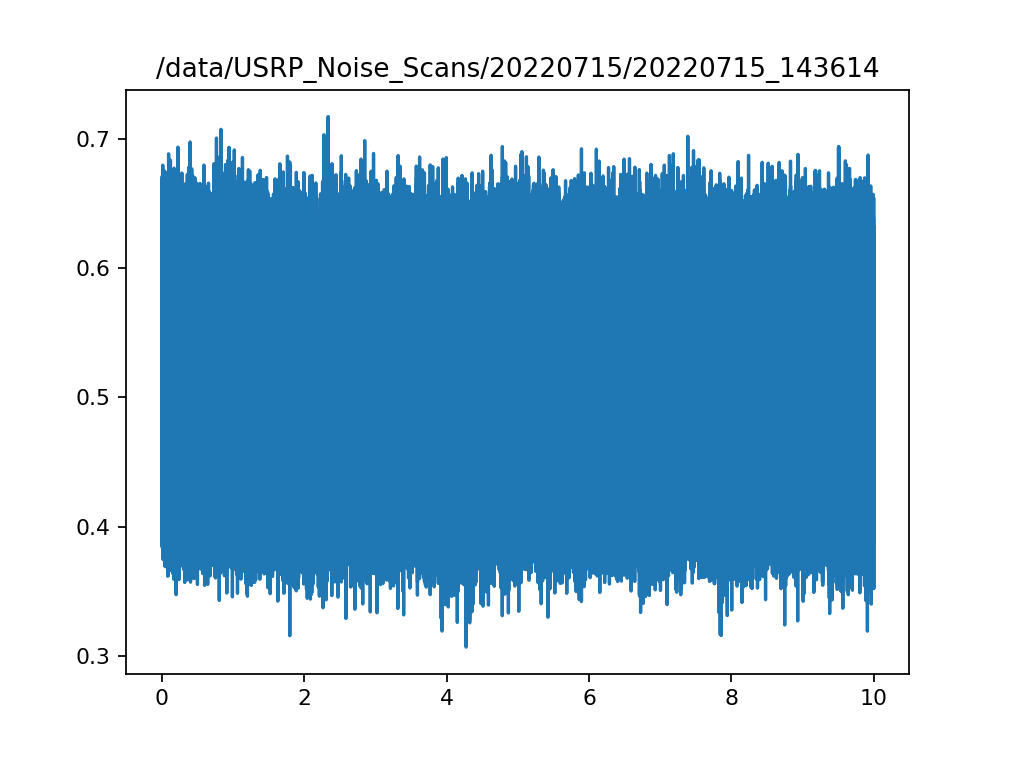

In [6]:
# for i in range(10,20):
#     if(i < 10):
#         idStr='000'+str(i)
#     elif (i < 100):
#         idStr='00'+str(i)
#     else:
#         idStr = '0'+str(i)
#     fileStr = tone_files[1]
# #     fileStr='/data/USRP_Noise_scans/long_timestream/mkid11-b-'+idStr+'.np'
#     res = readDataFile(fileStr)
    
#     plt.figure(fileStr)
#     plt.plot(res['Time'],res['Phase'])
#     plt.title(fileStr)
# #     print(len(res['Phase']))
#     del res
#     plt.show()
    
res = readDataFile(data_path)
    
plt.figure()
plt.plot(res['Time'][res['cut_idx']:],res['Phase'][res['cut_idx']:])
plt.title(data_path)
#     print(len(res['Phase']))
del res
# plt.show()

Line Delay file:  /data/USRP_Noise_Scans/20220715/20220715_143614/USRP_Delay_20220715_143614.h5
VNA scan file:    /data/USRP_Noise_Scans/20220715/20220715_143614/USRP_VNA_20220715_143614.h5
Timestream files: ['/data/USRP_Noise_Scans/20220715/20220715_143614/USRP_Noise_20220715_143614_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220715/20220715_143614/noise_averages_20220715_143614.h5


<IPython.core.display.Javascript object>


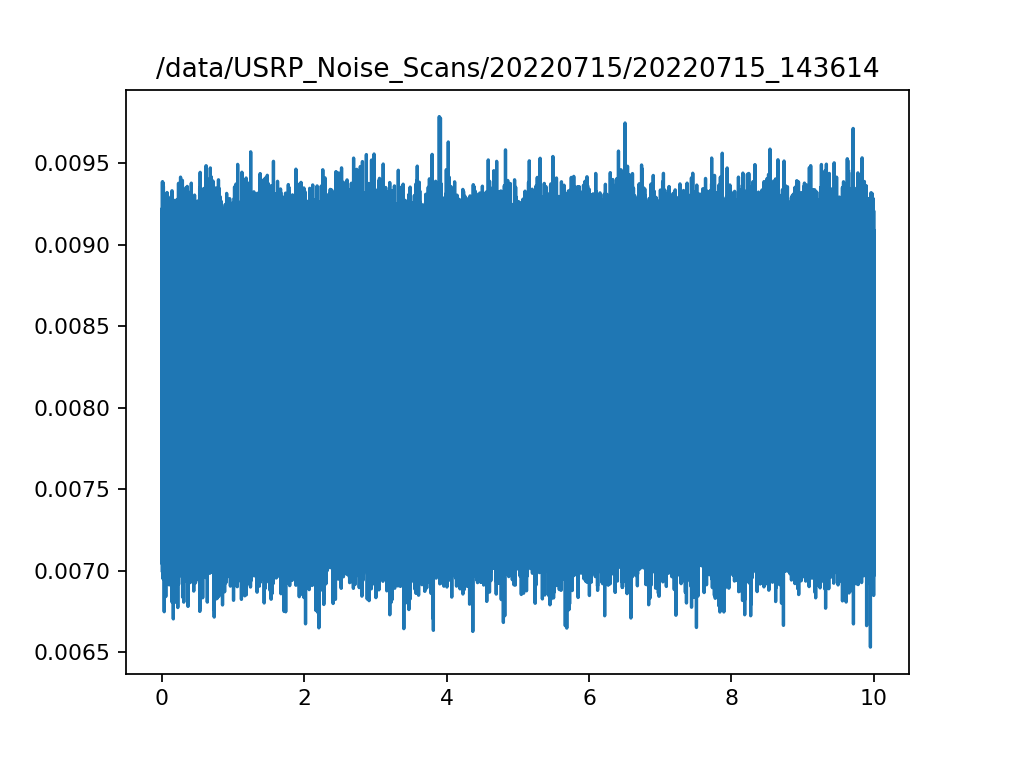

In [10]:
res = readDataFile(data_path)
    
plt.figure()
plt.plot(res['Time'][res['cut_idx']:],res['Magnitude'][res['cut_idx']:])
plt.title(data_path)
#     print(len(res['Phase']))
del res
# plt.show()

In [37]:
def pulse(x,x0,tau1=20e-6,tau2=200e-6):
    dx=(x-x0)
    dx*=np.heaviside(dx,1)
    return (np.exp(-dx/tau1)-np.exp(-dx/tau2))/(tau1-tau2)*np.heaviside(dx,1)

def pulseFromTemplate(template,noisepsd,fs):
    
    # calculate the time-domain optimum filter
    phi = irfft(rfft(template)/noisepsd).real
    # calculate the normalization of the optimum filter
    norm = np.dot(phi, template)
        
    # calculate the expected energy resolution
    resolution = 1.0/(np.dot(phi, template)/fs)**0.5
    
    template = phi/norm*fs
    
    return template,[phi,norm,resolution]

def getEvents(filename, trig_channel='Phase', trig_th = 2.0, rising_edge = True, maxAlign=True,
       pretrig = 1024, trace_len = 4096, trig_sep = 4096, ds=4, pretrig_template = 1024, tauRise=20e-6, tauFall=300e-6,  
                                     ACcoupled=True, verbose=False, template=None):
    '''
    This function takes data from continuous DAQ, where each file contains 1 sec of data
    It slices the 1sec of data into events with a level trigger
    
    Double exponential template is generated if no template is given. For OF template, run 'pulseFromTemplate' to generate
    apropriate template for use with trigger function
    
    '''
    res=readDataFile(filename)
    chan_names=res['chan_names']
    number_samples=res['number_samples']
 
    #make sure trigger channel is valid
    chan_names = res['chan_names']
    if(trig_channel not in chan_names):
        trig_channel='Phase'
        if(verbose):
            print('Trigger Channel Defaulting to Phase')
 
    #setup trigger template
    fs=res['Fs']
    dt=1.0/fs
    if(template is None):
        #produce shaping template
        pretrigger=pretrig_template*dt
        xtemplate=np.arange(0,trace_len)*dt
        template=pulse(xtemplate,pretrigger,tau1=tauRise,tau2=tauFall)
    else:
        oldtl = trace_len
        trace_len = len(template)
        if(oldtl == trig_sep):
            trig_sep = trace_len
        pretrig_template = np.argmax(template)
        xtemplate=np.arange(0,trace_len)*dt    
    
    if(ACcoupled): #removes DC component; flat trace gives 0
        template-=np.mean(template)
 
    trace=res[trig_channel]
    #downsample and average template and trace
    meandt=dt*ds
    trig_sep_ds = int(trig_sep/ds)
    meanTemplate=np.mean(template.reshape(int(len(template)/ds),ds),axis=1)
    meanTrace=np.mean(trace.reshape(int(len(trace)/ds),ds),axis=1)
 
    #pulse shaping maintainin correct amplitude
    filtered_data = scipy.signal.fftconvolve(meanTrace, meanTemplate[::-1], mode="valid")
    #filtered_data = np.correlate(meanTrace,meanTemplate)*meandt
#     plt.plot(filtered_data)
#     plt.show()
 
    if (rising_edge): #rising edge
        if(verbose):
            print('Triggering on rising edge')
        trigA = (filtered_data[0:-1] < trig_th)
        trigB = (filtered_data[1:] > trig_th)
    else: #falling edge
        if(verbose):
            print('Triggering on falling edge')
        trigA = (filtered_data[0:1] > trig_th)
        trigB = (filtered_data[1:] < trig_th)
    trigger_condition = trigA & trigB
    trigger_points=np.flatnonzero(trigger_condition)+1
 
    rm_index = []
    n_trig = len(trigger_points)
    n_trig_pts = n_trig
    idx = 0
    alignPreTrig = 200
    alignPostTrig =500
    while (idx < n_trig-2):
 
        #remove redundant triggers
        nidx = idx + 1
        while ( (nidx< n_trig) and ((trigger_points[nidx] - trigger_points[idx])< trig_sep_ds) ):
            rm_index.append(nidx)
            nidx += 1
 
        #update loop
        idx = nidx
 
    if(len(rm_index) > 0):
        rm_index = np.array(rm_index)
        trigger_points = np.delete(trigger_points, rm_index)
 
    #align trigger with pulse maximum                                                                                                                                         
    if(maxAlign):
        for idx in range(0,len(trigger_points)):
            trigWindowStart=trigger_points[idx] - int(alignPreTrig/ds)
            trigWindowEnd=trigger_points[idx] + int(alignPostTrig/ds)
            if(trigWindowStart > 0 and trigWindowEnd < len(filtered_data)):
                trigger_points[idx] = np.argmax(filtered_data[trigWindowStart:trigWindowEnd])+trigWindowStart
 
    if(ds > 1):
        trigger_points*=ds
    trigger_points += pretrig_template
    n_trig = len(trigger_points)
 
    for ch_str in chan_names:
        rm_index = []
        singleTrace=res[ch_str]
        res[ch_str] = []
        for i in range(0,len(trigger_points)):            
            trigpt = trigger_points[i]
 
            #avoid traces too close to the edge of the trace
            trigAreaStart=trigpt - pretrig
            trigAreaEnd=trigpt + trace_len - pretrig
            if(trigAreaStart < 0 or trigAreaEnd > len(singleTrace)):
                rm_index.append(i)
                continue
            res[ch_str].append(singleTrace[trigAreaStart:trigAreaEnd])
        if(len(rm_index) > 0):
            rm_index = np.array(rm_index)
            trigger_points = np.delete(trigger_points, rm_index)
        res[ch_str] = np.array(res[ch_str])
 
    res['trigpt'] = trigger_points
    res['filename'] = np.full(n_trig,filename)
    res['trigRate'] = np.full(n_trig,n_trig)
    res['trigPts'] = np.full(n_trig,n_trig_pts)
 
    del singleTrace
    del filtered_data
    del trigger_condition
    del trigA,trigB
 
    return res

In [16]:
# traceLength=8096
# pulseCount=0
# traces = {}
# for i in range(0,900):
#     if(i < 10):
#         idStr='000'+str(i)
#     elif (i < 100):
#         idStr='00'+str(i)
#     else:
#         idStr = '0'+str(i)
#     fileStr='long_timestream/mkid11-b-'+idStr+'.np'
    
#     try:
#         events=getEvents(fileStr,ds=1,trig_th=200000.0, trace_len = traceLength, trig_sep = traceLength, tauFall=500e-6)
#         nEvents=len(events['Phase'])
#         for i in range(0,nEvents):
#             pulseCount+=1
#             trace=events['Phase'][i]
#             trace -= numpy.mean(trace[0:800])
#             traces[pulseCount] = trace
            
#     except:
#         print('Skipping '+fileStr)
#         print('there was an error and you should probably do some digging')
#     #xlim(0.5,3)
#     #ylim(-0.25,0.5)
# print(pulseCount)

In [38]:
def movavg(x,y,side_pts=3):
    
    lgth = 0
    if not (len(x) == len(y)):
        print("x and y must be the same size")
        return None
    else:
        lgth = len(x)
        
    
    if (len(x) % 2 == 0 ):
        x = x[:-1]
        y = y[:-1]
    
    if not (type(x) == type(np.array([0]))):
        x = np.array(x)
        
    x_pts = x[side_pts:-side_pts]
        
    n_pts = 1 + 2*side_pts
#     y_avg = np.array([ np.sum(y[i-side_pts:i+side_pts])/n_pts for i in  side_pts+np.arange(lgth-n_pts)])
    y_avg = np.convolve(x, np.ones(n_pts), 'valid') / n_pts
    
    return x_pts, y_avg

# Phase Response

Line Delay file:  /data/USRP_Noise_Scans/20220720/20220720_150715/USRP_Delay_20220720_150715.h5
VNA scan file:    /data/USRP_Noise_Scans/20220720/20220720_150715/USRP_VNA_20220720_150715.h5
Timestream files: ['/data/USRP_Noise_Scans/20220720/20220720_150715/USRP_Noise_20220720_150715_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220720/20220720_150715/noise_averages_20220720_150715.h5
632


<IPython.core.display.Javascript object>


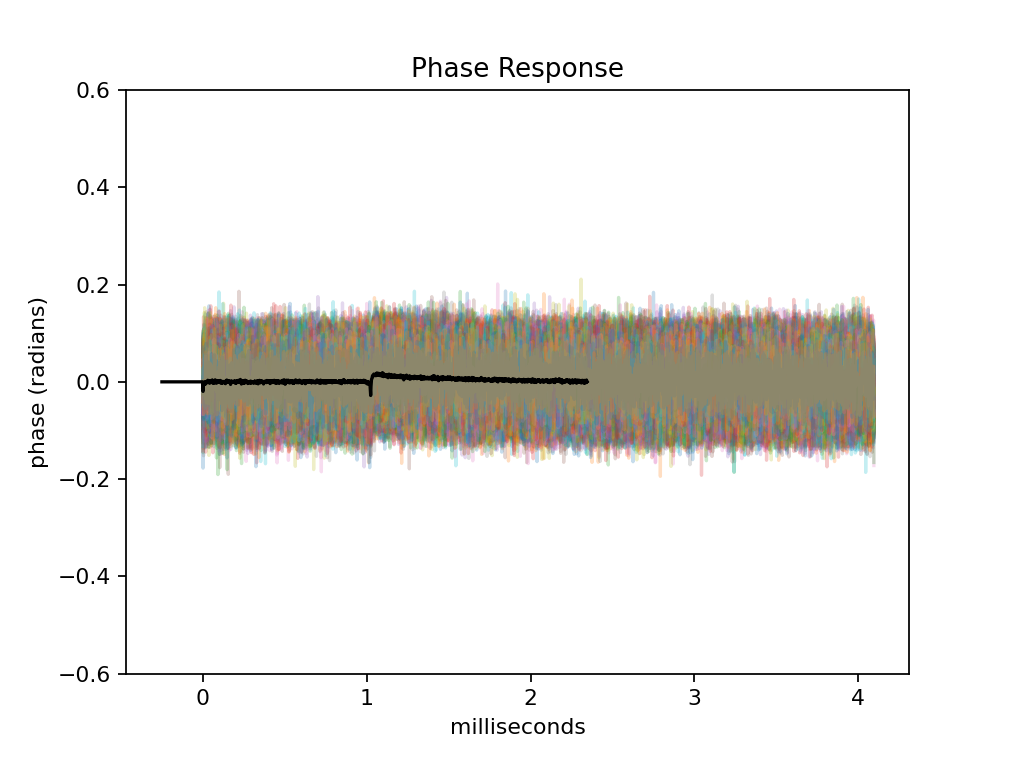

(-0.6, 0.6)

In [39]:
traceLength=4096
pulseCount=0
traces = {}

events=getEvents(data_path,ds=1,trig_th=5.0e3, trace_len = traceLength, trig_sep = traceLength, tauFall=500e-6)
nEvents=len(events['Phase'])
for i in range(0,nEvents):
    pulseCount+=1
    trace=events['Phase'][i]
    trace -= numpy.mean(trace[0:800])
    traces[pulseCount] = trace

print(pulseCount)

plt.figure()

_tint = numpy.arange(-250,traceLength-1750)/1e3
avg_trace = np.zeros(len(_tint))
n_traces = 0

doAlign = False

for pulseNum in traces:
    if (pulseNum < 100) or True:
        
        
        trace = traces[pulseNum]
        
        ## Line up the traces
        pos_max = np.argmax(trace) if doAlign else 0
        tidxs = numpy.arange(0,traceLength)
        tvals = (tidxs-pos_max)/1e3
        
        if doAlign and (pos_max<500 or pos_max>1500):
            continue
        
        _intp = interp1d(tvals,trace,bounds_error=False,fill_value=0)
        _trin = _intp(_tint)
        
        avg_trace += _intp(_tint)
        avg_tvals  = _tint
        n_traces  += 1
        
        plt.plot(tvals,trace,alpha=0.25)
        
avg_trace /= n_traces
plt.plot(avg_tvals,avg_trace,color='k')

# plt.ylabel('magnitude')
plt.ylabel('phase (radians)')
plt.xlabel('milliseconds')
# plt.title('Examples of detected phonon pulses')
plt.title('Phase Response')
# plt.ylim([-0.30,0.30])
# plt.ylim([-0.20,0.40])
plt.ylim([-0.60,0.60])

In [41]:
print(events.keys())
print(events["trigpt"]/1e6)
print(len(events["trigpt"]))

dict_keys(['Phase', 'Magnitude', 'Time', 'Fs', 'number_samples', 'chan_names', 'cut_idx', 'trigpt', 'filename', 'trigRate', 'trigPts'])
[8.394000e-03 1.478800e-02 2.964200e-02 3.438000e-02 4.816200e-02
 5.811900e-02 7.759700e-02 9.000800e-02 9.887900e-02 1.083080e-01
 1.357540e-01 1.416860e-01 1.699340e-01 1.839740e-01 1.881770e-01
 1.990210e-01 2.153680e-01 2.763740e-01 2.810620e-01 2.928390e-01
 3.040810e-01 3.208860e-01 3.257880e-01 3.304080e-01 3.366090e-01
 3.434570e-01 3.478890e-01 3.534710e-01 4.047240e-01 4.174890e-01
 4.521710e-01 4.707410e-01 4.994720e-01 5.130430e-01 5.189140e-01
 5.513410e-01 5.617130e-01 5.779910e-01 5.873270e-01 5.977740e-01
 6.132430e-01 6.552320e-01 6.733770e-01 6.805060e-01 7.188780e-01
 7.242320e-01 7.451810e-01 8.175020e-01 8.314200e-01 8.372870e-01
 8.468770e-01 8.552310e-01 8.638280e-01 8.768620e-01 8.825520e-01
 9.175980e-01 9.426940e-01 9.530310e-01 9.757400e-01 9.844330e-01
 1.000705e+00 1.004905e+00 1.013772e+00 1.027962e+00 1.061892e+00
 1.075

<IPython.core.display.Javascript object>


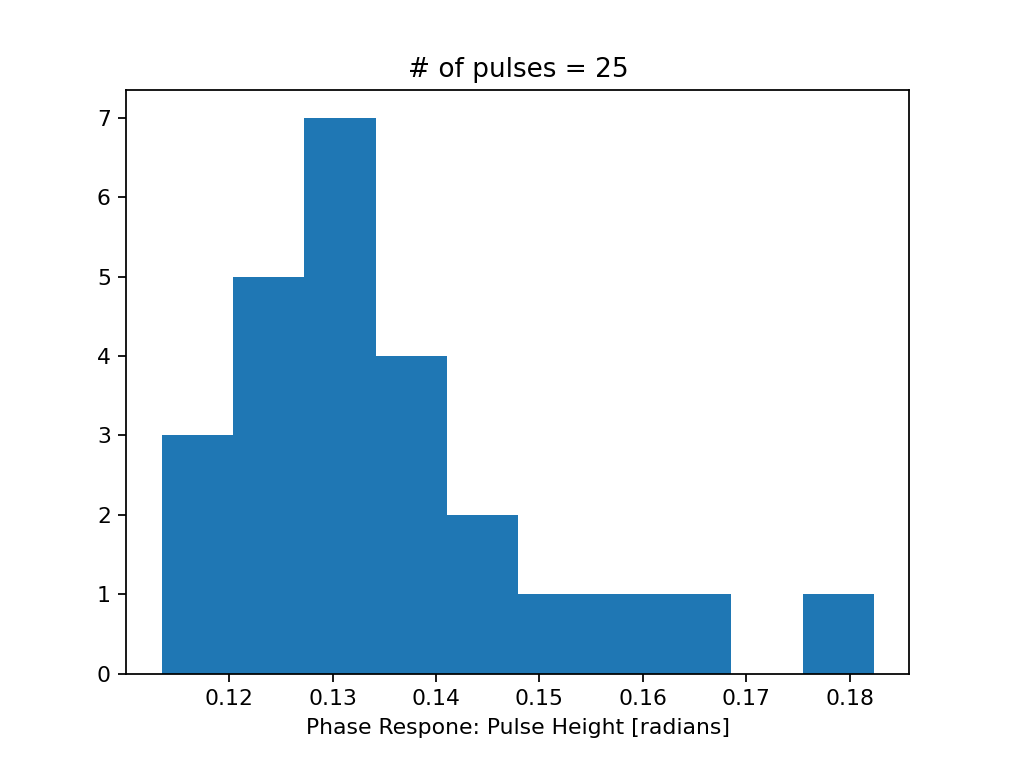

<IPython.core.display.Javascript object>


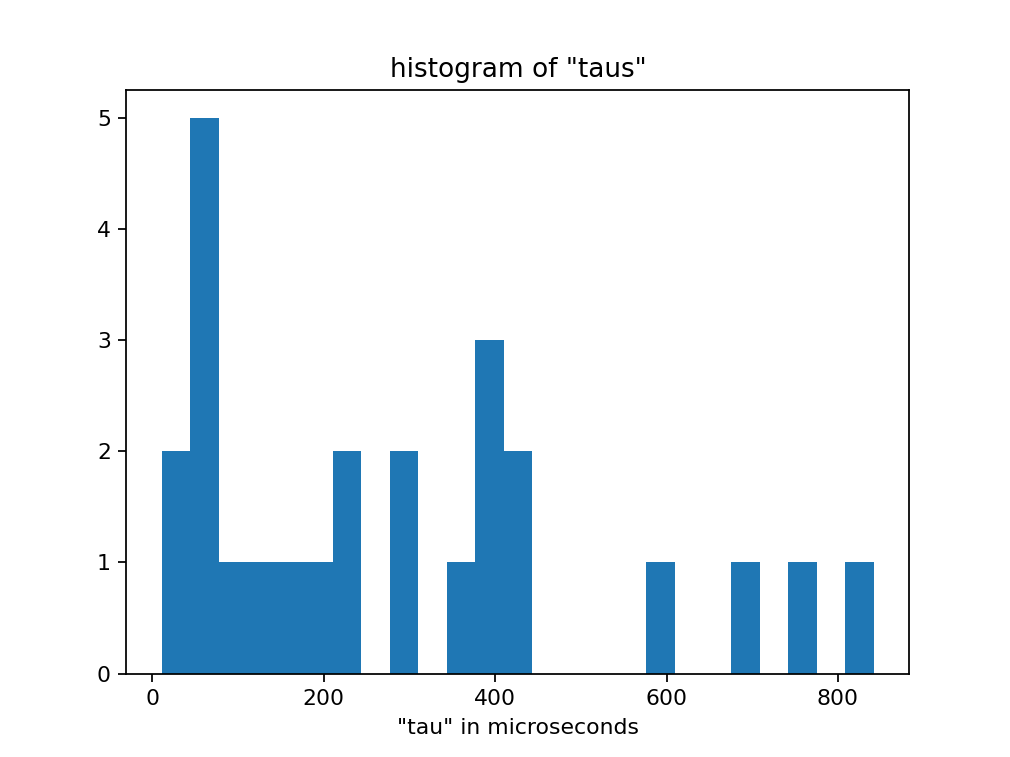

In [19]:
# %matplotlib inline
pulse_heights = []
taus = []
# interestingPulses = []
# interestingPulseHeights = []
for pulseNum in traces:
    trace = traces[pulseNum]
    pulse_max = np.amax(trace[1000:2000])
    pulse_heights.append(pulse_max)
    pulse_max_idxs = np.argwhere(trace == pulse_max)
    pulse_max_idx = pulse_max_idxs[0][0]
    trace_after_pulse = trace[pulse_max_idx:pulse_max_idx+1000]
    tau = np.argmin(np.abs(trace_after_pulse - pulse_max/np.e))
    taus.append(tau)
    
#     if tau > 600 and tau < 800:
#         interestingPulses.append(pulseNum)
#         interestingPulseHeights.append(pulse_max)

        
# height_bins = np.linspace(0.1,4.1,30)
plt.figure()
plt.hist(pulse_heights)#,bins=height_bins)
# plt.xlabel('Magnitude Response: Pulse Height')
plt.xlabel('Phase Respone: Pulse Height [radians]')
plt.title('# of pulses = '+str(len(traces)))
plt.savefig('pulse_heights.png')

plt.figure()
plt.xlabel('"tau" in microseconds')
plt.title('histogram of "taus"')
plt.hist(taus,bins=25)
plt.savefig('pulse_lifetimes.png')

# plt.figure('interesting pulse heights')
# plt.hist(interestingPulseHeights,bins = height_bins)
# plt.xlabel('radians')
# plt.title('only plotting taus between 200 and 600 microseconds')
# plt.savefig('pulse_heights_lifetime_cut.png')
# plt.show()

# Magnitude Response

Line Delay file:  /data/USRP_Noise_Scans/20220715/20220715_143614/USRP_Delay_20220715_143614.h5
VNA scan file:    /data/USRP_Noise_Scans/20220715/20220715_143614/USRP_VNA_20220715_143614.h5
Timestream files: ['/data/USRP_Noise_Scans/20220715/20220715_143614/USRP_Noise_20220715_143614_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220715/20220715_143614/noise_averages_20220715_143614.h5
1064


<IPython.core.display.Javascript object>


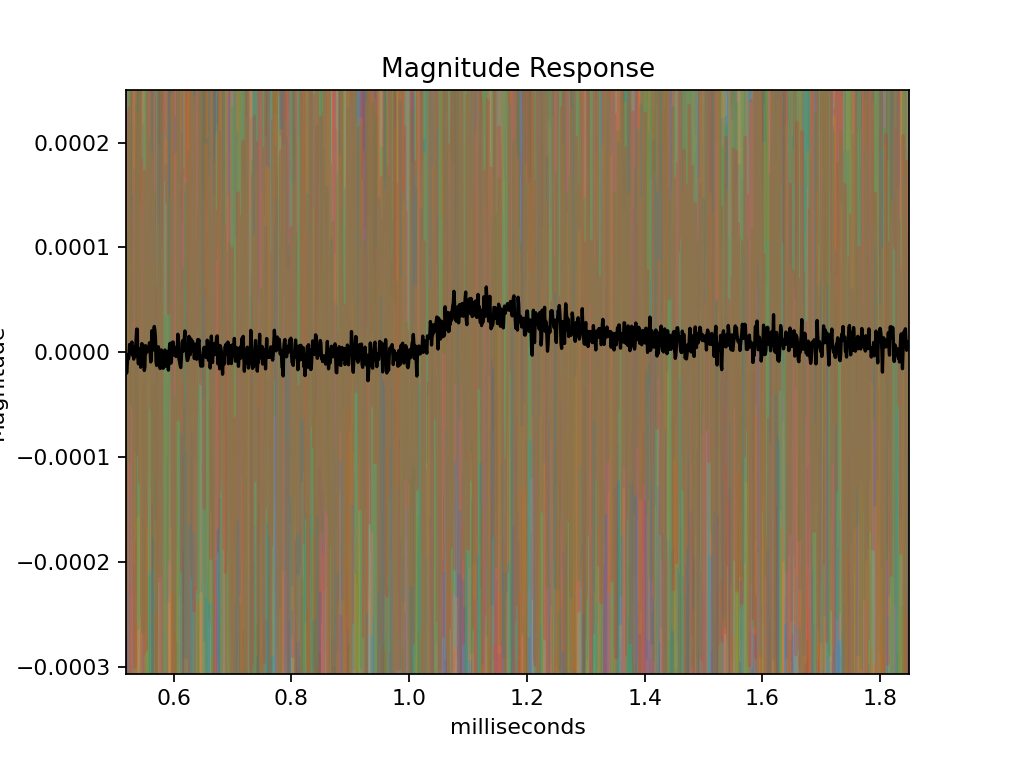

(-0.002, 0.003)

In [31]:
traceLength=4096
pulseCount=0
traces = {}

events=getEvents(data_path,ds=1,trig_th=5.0e3, trace_len = traceLength, trig_sep = traceLength, tauFall=500e-6)
nEvents=len(events['Magnitude'])
for i in range(0,nEvents):
    pulseCount+=1
    trace=events['Magnitude'][i]
    trace -= numpy.mean(trace[0:800])
    traces[pulseCount] = trace

print(pulseCount)

plt.figure()

_tint = numpy.arange(-250,traceLength-1250)/1e3
avg_trace = np.zeros(len(_tint))
n_traces = 0

doAlign = False

for pulseNum in traces:
    if (pulseNum < 100) or True:
        
        
        trace = traces[pulseNum]
        
        ## Line up the traces
        pos_max = np.argmax(trace) if doAlign else 0
        tidxs = numpy.arange(0,traceLength)
        tvals = (tidxs-pos_max)/1e3
        
        if doAlign and (pos_max<500 or pos_max>1500):
            continue
        
        _intp = interp1d(tvals,trace,bounds_error=False,fill_value=0)
        _trin = _intp(_tint)
        
        avg_trace += _intp(_tint)
        avg_tvals  = _tint
        n_traces  += 1
        
        plt.plot(tvals,trace,alpha=0.25)
        
avg_trace /= n_traces
plt.plot(avg_tvals,avg_trace,color='k')
        
# plt.ylabel('magnitude')
plt.ylabel('Magnitude')
plt.xlabel('milliseconds')
# plt.title('Examples of detected phonon pulses')
plt.title('Magnitude Response')
# plt.ylim([-0.0075,0.025])
# plt.ylim([-0.003,0.008])
plt.ylim([-0.002,0.003])

<IPython.core.display.Javascript object>


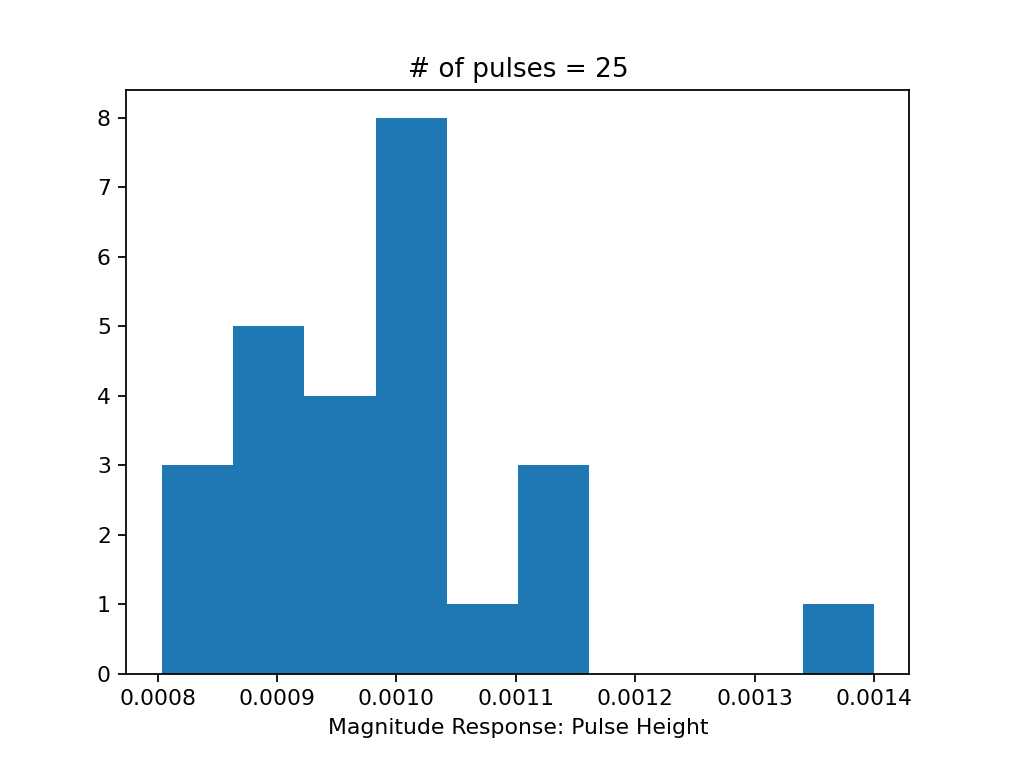

<IPython.core.display.Javascript object>


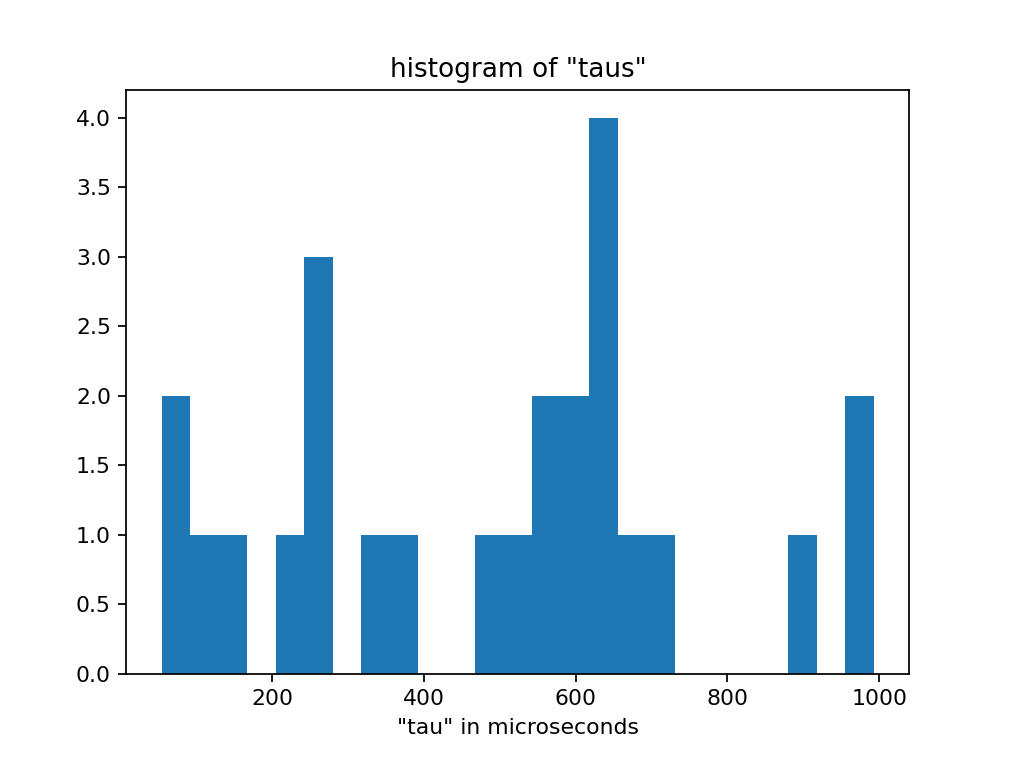

In [21]:
# %matplotlib inline
pulse_heights = []
taus = []
# interestingPulses = []
# interestingPulseHeights = []
for pulseNum in traces:
    trace = traces[pulseNum]
    pulse_max = np.amax(trace[1000:2000])
    pulse_heights.append(pulse_max)
    pulse_max_idxs = np.argwhere(trace == pulse_max)
    pulse_max_idx = pulse_max_idxs[0][0]
    trace_after_pulse = trace[pulse_max_idx:pulse_max_idx+1000]
    tau = np.argmin(np.abs(trace_after_pulse - pulse_max/np.e))
    taus.append(tau)
    
#     if tau > 600 and tau < 800:
#         interestingPulses.append(pulseNum)
#         interestingPulseHeights.append(pulse_max)

        
# height_bins = np.linspace(0.1,4.1,30)
plt.figure()
plt.hist(pulse_heights)#,bins=height_bins)
plt.xlabel('Magnitude Response: Pulse Height')
# plt.xlabel('Phase Respone: Pulse Height [radians]')
plt.title('# of pulses = '+str(len(traces)))
plt.savefig('pulse_heights.png')

plt.figure()
plt.xlabel('"tau" in microseconds')
plt.title('histogram of "taus"')
plt.hist(taus,bins=25)
plt.savefig('pulse_lifetimes.png')

# plt.figure('interesting pulse heights')
# plt.hist(interestingPulseHeights,bins = height_bins)
# plt.xlabel('radians')
# plt.title('only plotting taus between 200 and 600 microseconds')
# plt.savefig('pulse_heights_lifetime_cut.png')
# plt.show()

In [22]:
np.round(0.12453,3)

0.125